# Data Prep: Classification (exercise)

In this notebook we will use data on house sales in King County, Washington state to predict house prices using simple (one input) linear regression using Scikit-Learn. Scikit-Learn is a simple, efficient and well-designed tool for data analysis and machine learning. You will use it and seaborn to:

    Use Python to load, visualize and prepare the data
    Use SciKit-Learn functions to compute important summary statistics
    Use matplotlib and Seaborn to plot and visualize the data
    Fix nulls and zeros
    Convert price to a form suitable for classification
    Divide dataset into train and test subsets
    Scale the features
    Run: Random Forests, Support Vector Machines, and Neural Net

In this notebook you will be provided with mostly complete code. The goal here is to use classification to model the dataset and gain experience with Scikit-Learn.  You will use classification to sort homes into two catagories and compare predicted versus actual results. Clearly this a simplified problem, but easy to understand for new data scientists.

First, we need to load all of the appropriate libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [2]:
housing = pd.read_csv("kc_house_data2.csv")

In [3]:
housing.shape

(21613, 21)

In [4]:
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,0,3.0,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,0,3.0,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2.0,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4.0,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3.0,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


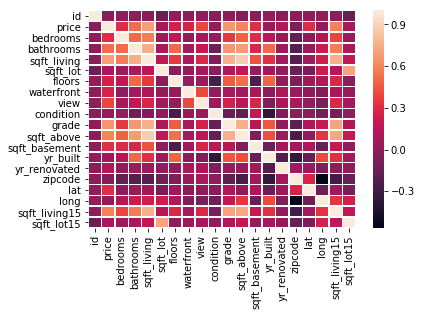

In [5]:
sns.heatmap(housing.corr(), linewidths=.5)

First, let's drop the features that don't correlate well with price.  Although we don't do it in this exercise, you might also create new features like bathrooms squared.  Squaring a feature like bathrooms makes each incremental bathroom more valuable.

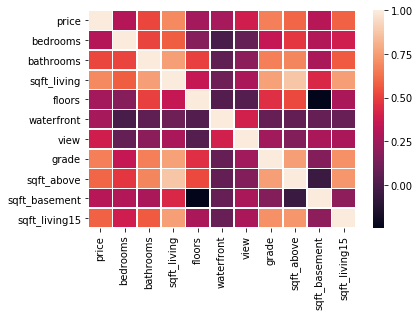

In [6]:
drop_list = ['id', 'sqft_lot', 'condition', 'yr_built', 'yr_renovated', 'zipcode',
             'sqft_lot15', 'lat', 'long', 'date']
housing.drop(drop_list, axis=1, inplace=True)
sns.heatmap(housing.corr(), linewidths=.5)

Clearing out the unused features leaves us with 10 potentially useful features. 

In [7]:
housing.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,sqft_above,sqft_basement,sqft_living15
0,0,3.0,1.00,1180,1.0,0,0,7,1180,0,1340
1,0,3.0,2.25,2570,2.0,0,0,7,2170,400,1690
2,180000,2.0,1.00,770,1.0,0,0,6,770,0,2720
3,604000,4.0,3.00,1960,1.0,0,0,7,1050,910,1360
4,510000,3.0,2.00,1680,1.0,0,0,8,1680,0,1800


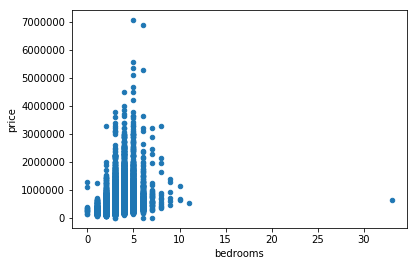

In [8]:
housing.plot(kind="scatter", x="bedrooms", y="price")

We saw this plot in the Regression session.  It looks linear; however, it appears that there distribution in not "normal" but skews towards lower price houses.  Here is a plot:

In [ ]:
hist = housing['price']
sns.distplot(hist)
housing['price'].mean()

This is clearly not a normal distribution.  Just looking at the plot, the mean appears to be around 500k.  Now we need to remove any nulls.  Luckily we have funtions to help with this,

In [ ]:
housing.isnull().sum()

In [ ]:
housing.fillna(value=5, inplace=True)
housing.isnull().sum()

Ok, we filled in nulls arbitrarily with the numeric value 5.  This is close to a mean value and it is unlikely that four houses with wrong bedrooms nor one house with 5 floors is a problem.  Next we need to fill in zeros, i.e. cases where the price is zero.  Clearly selling a house for zero is an incorrect value, and will skew the results.  Let's fill them in with the mean.

In [ ]:
housing[housing.price == 0]

Good, we only have four cases.  Rather than use the mean we could use the results from a linear regression model or use MICE, but with only four holes it is not worth the effort.

In [ ]:
col_sum = housing.sum(axis=0)
print(col_sum)

In [ ]:
housing.shape

In [ ]:
mean = (col_sum.price)/(21613-4)
print(mean)

We can now replace the zeros with the mean.  As you can see from the first 5 rows we have fixed the first two rows.

In [ ]:
housing.price.replace(to_replace=0, value=mean, inplace=True)
housing.head()

For classification we want to assign each row to a category.  Therefore, we need to convert the price column into a label.  Our assignment here is to find house in the top 50% of the market so we will have to roughly divide the dataset in half.  Recall that our mean is around 500k.

In [ ]:
mybins = [2, 500000, 9000000]
group_names = ['too_low', 'good']
housing['price'] = pd.cut(housing['price'], bins=mybins, labels = group_names)
housing['price'].value_counts()

Good, although we started with the mean, we see that there are more lower priced houses.  If we need 50/50 by quantity then we would need to figure what price is the median.  But this split is perfect for now.  The algorithms don't work well with labels, so our next step is too enclode each category.  Since we only have two categories, we only need 0 and 1.

In [ ]:
housing.head()

In [ ]:
new_price = LabelEncoder()
housing['price'] = new_price.fit_transform(housing['price'])
housing['price'].value_counts()

It might be interesting to plot the counts.

In [ ]:
sns.countplot(housing['price'])

Now we are going to split the data set into features versus correct answers (i.e. encoded price)

In [ ]:
X = housing.drop('price', axis=1)
y = housing['price']

Some routines may complain about float64 versus int64 so let's convert everything to float64

In [ ]:
X.info()

In [ ]:
X = X.astype(float)
X.info()

In [ ]:
y = y.astype(float)

This is the traditional split for creating some test data.  Luckily there is a handy routine for this!

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

If the various features are not on the same scale they can bias the results.  Therefore it makes sense to scale the features via StandardScaler.  **Warning: if you scale the training set, then you need to scale the test set.** Notice that we fit and transform the training but only trainsform the test set.

In [ ]:
myscaler = StandardScaler()
X_train = myscaler.fit_transform(X_train)
X_test = myscaler.transform(X_test)

# Random Forests

In [ ]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
predict_rfc = rfc.predict(X_test)

In [ ]:
print(classification_report(y_test, predict_rfc))
print(confusion_matrix(y_test, predict_rfc))

# Support Vector Classifier

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)
predict_svc = svc.predict(X_test)

In [ ]:
print(classification_report(y_test, predict_svc))
print(confusion_matrix(y_test, predict_svc))

# Neural Network

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(10,10,10),max_iter=1000)
mlp.fit(X_train, y_train)
predict_mlp = mlp.predict(X_test)

In [ ]:
print(classification_report(y_test, predict_mlp))
print(confusion_matrix(y_test, predict_mlp))